In [1]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import DOWNSTREAM_RESULTS_DIR
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import SUPPORTED_BASELINES
from mood.utils import get_outlier_bounds
from mood.metrics import Metric

/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SUBDIR = "20221213"

In [3]:
in_dir = dm.fs.join(DOWNSTREAM_RESULTS_DIR, "dataframes", "compare_performance", SUBDIR)
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [4]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, SUPPORTED_BASELINES, MOOD_REPRESENTATIONS))
assert list(all_triplets) == len(paths), find_missing(paths, all_triplets)

AssertionError: Missing 33:
('BBB', 'GP', 'ChemBERTa')
('BBB', 'GP', 'Desc2D')
('BBB', 'GP', 'ECFP6')
('BBB', 'GP', 'Graphormer')
('CYP2C9', 'GP', 'ChemBERTa')
('CYP2C9', 'GP', 'Desc2D')
('CYP2C9', 'GP', 'ECFP6')
('CYP2C9', 'GP', 'Graphormer')
('CYP2C9', 'GP', 'MACCS')
('CYP2C9', 'GP', 'WHIM')
('CYP2C9', 'MLP', 'ChemBERTa')
('CYP2C9', 'MLP', 'Desc2D')
('CYP2C9', 'MLP', 'ECFP6')
('CYP2C9', 'MLP', 'Graphormer')
('CYP2C9', 'MLP', 'MACCS')
('CYP2C9', 'MLP', 'WHIM')
('CYP2C9', 'RF', 'ChemBERTa')
('CYP2C9', 'RF', 'Desc2D')
('CYP2C9', 'RF', 'ECFP6')
('CYP2C9', 'RF', 'Graphormer')
('CYP2C9', 'RF', 'MACCS')
('CYP2C9', 'RF', 'WHIM')
('Caco-2', 'MLP', 'Graphormer')
('Caco-2', 'RF', 'ChemBERTa')
('Caco-2', 'RF', 'Graphormer')
('Lipophilicity', 'GP', 'ChemBERTa')
('Lipophilicity', 'GP', 'Desc2D')
('Lipophilicity', 'GP', 'WHIM')
('Lipophilicity', 'RF', 'ChemBERTa')
('Lipophilicity', 'RF', 'Desc2D')
('Lipophilicity', 'RF', 'Graphormer')
('Lipophilicity', 'RF', 'WHIM')
('PPBR', 'RF', 'ChemBERTa')


In [5]:
df_original = pd.concat([pd.read_csv(p) for p in tqdm.tqdm(paths)], ignore_index=True)
# The "P450" is actually not informative, but these results were generated before abbreviating the name
df_original["dataset"] = df_original["dataset"].apply(lambda x: "CYP2C9" if x == "CYPP4502C9" else x)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [01:26<00:00,  2.02it/s]


In [7]:
df_original.groupby(["type", "metric"])[["iid_score", "ood_score"]].describe()

iid_score                                            \
                            count       mean        std       min       25%   
type        metric                                                            
calibration Brier score      95.0   0.372166   0.132924  0.075731  0.285949   
            Spearman         79.0   0.203574   0.186495 -0.215391  0.065013   
performance AUROC            95.0   0.712959   0.117114  0.479990  0.655886   
            MAE              79.0  18.536448  27.887279  0.307306  0.654623   

                                                          ood_score  \
                               50%        75%         max     count   
type        metric                                                    
calibration Brier score   0.369157   0.461003    0.755181      95.0   
            Spearman      0.145727   0.336183    0.673074      79.0   
performance AUROC         0.735606   0.803708    0.886833      95.0   
            MAE          12.361436  29.245392  231.291733      79.0   

                                                                              \
                              mean        std       min       25%        50%   
type        metric                                                             
calibration Brier score   0.381046   0.139461  0.078527  0.297776   0.381372   
            Spearman      0.160237   0.190871 -0.187380  0.007749   0.129166   
performance AUROC         0.681401   0.103352  0.476090  0.617889   0.709430   
            MAE          19.032564  21.803813  0.311015  0.865851  14.057281   

                                                
                               75%         max  
type        metric                              
calibration Brier score   0.484035    0.763074  
            Spearman      0.258885    0.676177  
performance AUROC         0.756572    0.875109  
            MAE          32.724245  159.147614

In [8]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# Upscale the Spearman correlation to go from [-1, 1] to [0, 1]
df.loc[df["metric"] == "Spearman", "iid_score"] = (df["iid_score"] + 1) / 2
df.loc[df["metric"] == "Spearman", "ood_score"] = (df["ood_score"] + 1) / 2

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# Since we observed above that there is no negative scores
# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

# Invert the gap of metrics that need to be minimized, so that a high gap is always better
df["metric_direction"] = df["metric"].apply(lambda x: Metric.by_name(x).mode)
df.loc[df["gap"] == "min", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "min", "relative_gap"] = -df["relative_gap"]

df = df.rename(columns={"representation": "Representation", "dataset": "Dataset"})
df.head()

,Dataset,algorithm,Representation,iid_score,ood_score,metric,type,gap,relative_gap,metric_direction
0,BBB,GP,MACCS,0.788641,0.715417,AUROC,performance,-0.073225,-9.284907,max
1,BBB,GP,MACCS,0.281828,0.297942,Brier score,calibration,0.016114,-5.717549,min
2,BBB,GP,WHIM,0.619018,0.606398,AUROC,performance,-0.012620,-2.038756,max
3,BBB,GP,WHIM,0.755181,0.763074,Brier score,calibration,0.007893,-1.045191,min
4,BBB,MLP,ChemBERTa,0.790157,0.728571,AUROC,performance,-0.061586,-7.794106,max


<AxesSubplot: xlabel='relative_gap', ylabel='type'>

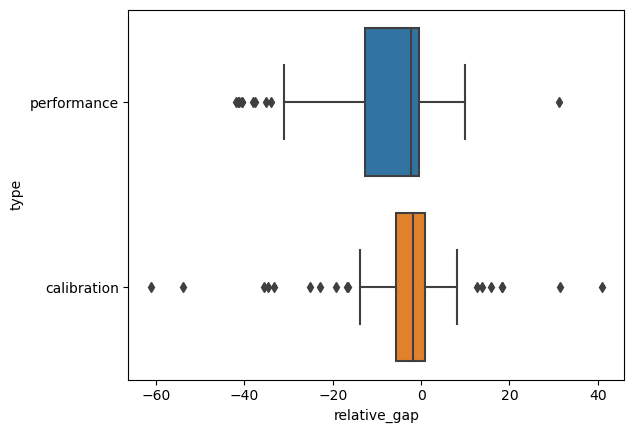

In [9]:
sns.boxplot(data=df, x="relative_gap", y="type")

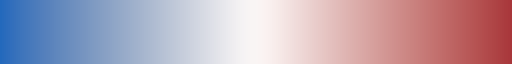

In [10]:
cmap = sns.color_palette("vlag", as_cmap=True)
cmap

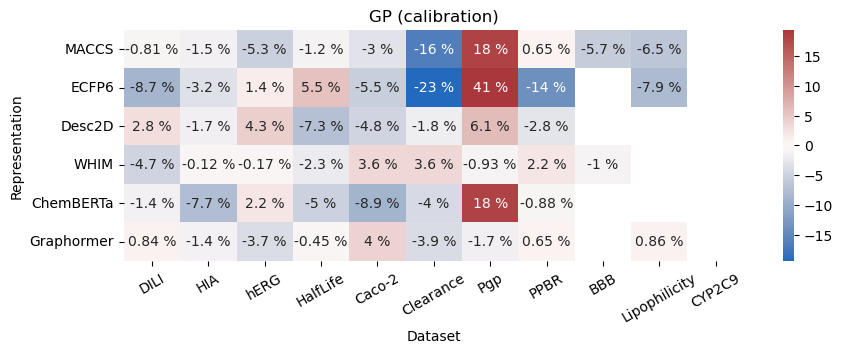

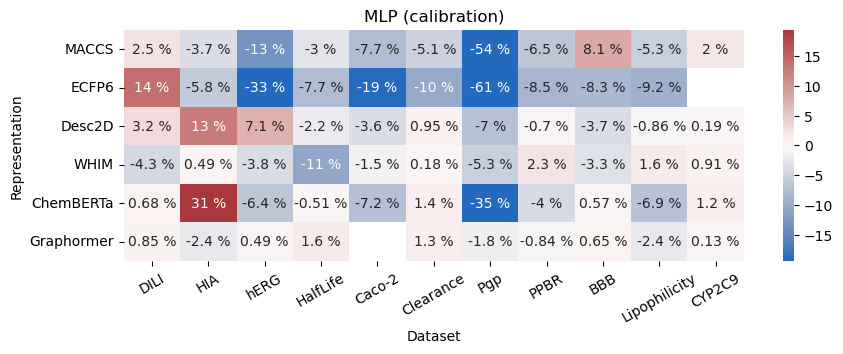

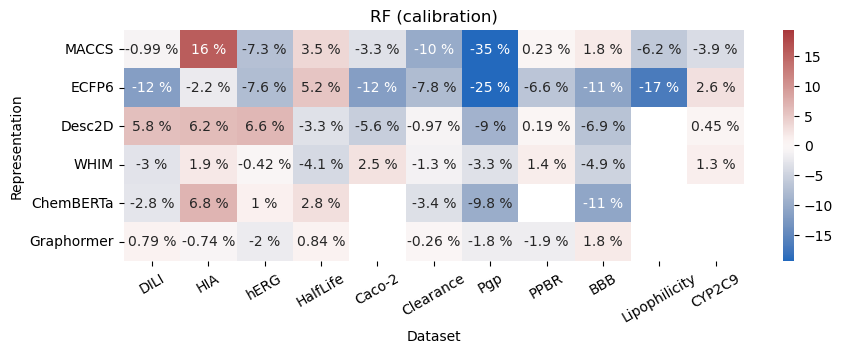

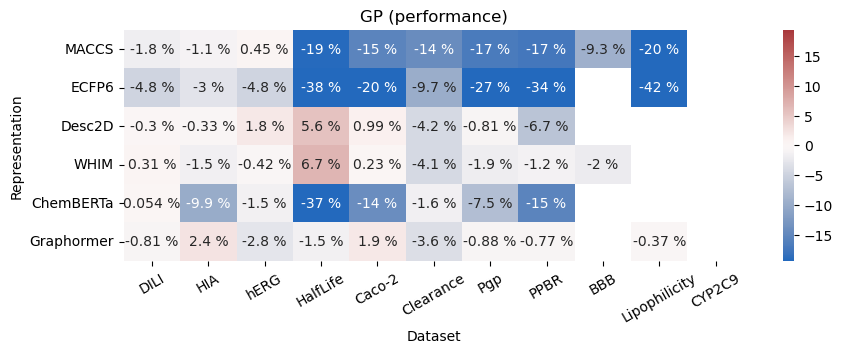

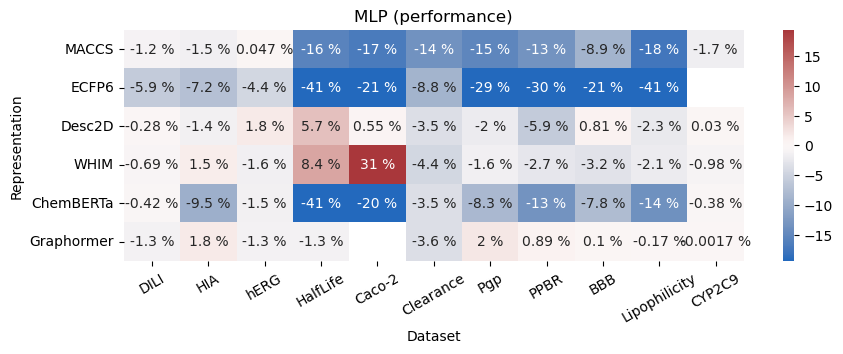

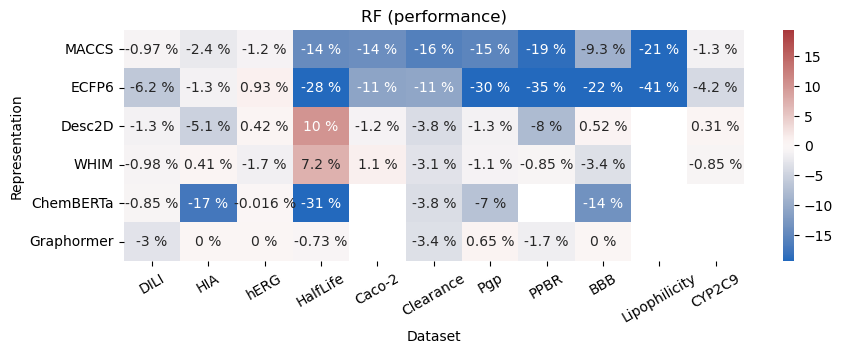

In [11]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for metric_type, metric_group in df.groupby("type"):
        
    for idx, (name, group) in enumerate(metric_group.groupby("algorithm")):
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot = group.pivot("Representation", "Dataset", metric)
        
        for c in MOOD_DATASETS: 
            if c not in pivot.columns:
                pivot[c] = np.nan
        pivot = pivot[MOOD_DATASETS]
        pivot = pivot.reindex(MOOD_REPRESENTATIONS)
        
        sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        for t in ax.texts: t.set_text(t.get_text() + " %")
        ax.set_title(f"{name} ({metric_type})")

The End.